# Import needed packages

In [1]:
# MESA modules

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# Other packages

import time
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

# Different styles to chose from

plt.style.use(['science','retro'])
# plt.style.use("ggplot")
# plt.style.use("Solarize_Light2")
# plt.style.use("dark_background")
# plt.style.use('science')
# plt.style.use(['science','ieee'])

In [2]:
seed1 = 1 
d_steps = 600
d_version = '26906a'
dynamic_firms = True
act_policies = 'base_scenario'

shock = {'shock_drop':-0.00, # it is relative pay attention and should be negative,
             'shock_duration':24,
             'shock_start':48 }

con_pref = {'increase':0.11666,   # 0.066666, 0.116666, 0.1666666 
             'con_duration':359,
             'con_start':1 }

imit_scen = {"e_f_r": [8,12],"b_f_r": [8,12],"g_f_r": [9.5,10.5]} 

firm_scen0 =  [{"e_f_r": [7,13],"b_f_r": [7,13],"g_f_r": [7,13],  
                "p_i_e": [0.2,0.4] , "p_i_g": [0.2,0.4] , "p_i_b": [0.2,0.4] ,
                "num": 100 }]                                       

policies = {"base_scenario":{'λ_e' : 1/3, 'λ_b' : 1/3,'λ_g' : 1/3,
                             'pp' : 10, 'λ_start' : 1, 'λ_dur' : 598, 'λ_off': 1,
                            #  'pp' : 10, 'λ_start' : 1, 'λ_dur' : 1, 'λ_off': 358,
                             'σ_g' : 0.8, 'P_r_l_g' : 1 }}

model_params = {'ω_g' : 0.1, 'ω_b' : 0.8, 'ω_c' : 0.1,      # Impact of innovation on GDP Growth
                'G_min' : 0.985, 'G_max' : 1.015,           # Exogenous GDP growth
                'M_e' : 40, 'γ_e' : 0.015, 'p_hat' : 250,   # Efficiency curve parameters
                'α' : 20, 'μ' : 0.2, 'ψ' : 0.9, 'Φ' : 0.15, # Firms' accounts
                'δ' : 0.3,                          
                'Pr_new' : 1/12,                            # Market dynamics 
                'η' : 0.85, 'Ω' : 0.85,
                'f_a' : 5}       

# Define the which uncertainty should be performed

In [1]:
num_rep = 100 # number of simulations for checking uncertainty
pol = 'PPF10L80CP045' # NoPol, L40, L60, L80, PP15, CP04, CP045, CP05
                # PP15L80C045, PP20L80C045, PP20L60C045 
                # PP15L80 , PP20L80, PP20L60, L80CP045
                # PPF10L80CP045
case = 'BaseCase' # BaseCase, MS1, MS2, Prnew1, Prnew2
uncer = "Inh" # Inh, Prgs, Kg , gamma_e1, gamma_e2, alpha1, alpha2 


### run the sensitivity

In [5]:
from Model import Agent, EconomyModel 

# Parameters defining the scenario 

#  Parameters used in the calculation of public procurement costs
temp_pp = policies[act_policies]['pp'] 
temp_λ_start = policies[act_policies]['λ_start'] 
temp_λ_dur = policies[act_policies]['λ_dur'] 
temp_λ_off = policies[act_policies]['λ_off'] 

cnt = 0 
payback_period = 36 # in months 
per_loan = policies['base_scenario']['σ_g'] # percentage of loan to firms revenue
# dictionary containing the agents that have defaulted the number of loans taken 
# and the sum of money that they defaulted

start = time.time()
sens_df = pd.DataFrame(columns = ['MSWA_g_2045','MSWA_g_2070','MSWA_b_2070','MSWA_e_2070','GDP','HHI_mean','HHI_max','HHI_min','Avg_firms',"Old2045",'Old2070','New2045','New2070','G_loans_per','Idle','G_loans','Cost_pp','Cost_lg'], index = range(num_rep))
for j in range(num_rep):
    seed1 = j + 1
    model = EconomyModel( seed1, d_steps, dynamic_firms, policies[act_policies],shock, con_pref,                          firm_scen0, imit_scen, model_params)
    for i in range(model.num_steps):
        model.step()
    model_df = model.dc.get_model_vars_dataframe()
    agent_df = model.dc.get_agent_vars_dataframe()
    agent_df = agent_df.reset_index()

    sens_df.loc[j,'MSWA_g_2045'] = model_df.MSWA_g.iloc[299] 
    sens_df.loc[j,'MSWA_g_2070'] = model_df.MSWA_g.iloc[599] 
    sens_df.loc[j,'MSWA_b_2070'] = model_df.MSWA_b.iloc[599] 
    sens_df.loc[j,'MSWA_e_2070'] = model_df.MSWA_e.iloc[599] 
    sens_df.loc[j,'GDP'] = model_df.ActualGDP.iloc[599] 
    sens_df.loc[j,'HHI_mean'] = model_df.HHI.mean() 
    sens_df.loc[j,'HHI_max'] = model_df.HHI.max() 
    sens_df.loc[j,'HHI_min'] = model_df.HHI.min() 
    sens_df.loc[j,'Avg_firms'] = model_df.agents.mean()
    

    new_agents = []
    for k in range(1,d_steps+1):
        temp_df = agent_df[agent_df.Step == k]
        new_agents.append(temp_df[temp_df.AgentID >= firm_scen0[0]['num']].AgentID.count())
    sens_df.loc[j,'Old2045'] = model_df.agents[299] - new_agents[299]
    sens_df.loc[j,'Old2070'] = model_df.agents[599] - new_agents[599]
    sens_df.loc[j,'New2045'] = new_agents[299]
    sens_df.loc[j,'New2070'] = new_agents[599]
    
    vc = agent_df.proj.value_counts()
    sens_df.loc[j,'G_loans_per'] = 100*vc["green"]/(vc["green"]+vc["efficiency"]+vc["quality"])
    sens_df.loc[j,'Idle'] = (sum(vc)-vc['green']-vc["efficiency"]-vc['quality'])/sum(vc)
    sens_df.loc[j,'G_loans'] = vc["green"]/4

    total_cost_pp = 0 
    for i in range(temp_λ_dur+temp_λ_off):
        if i < temp_λ_dur:
            total_cost_pp += model_df.iloc[i+temp_λ_start].ActualGDP*temp_pp/100
        else:
            total_cost_pp += model_df.iloc[i+temp_λ_start].ActualGDP*temp_pp/100*(1-1/temp_λ_off*(i-temp_λ_dur+1))
    
    sens_df.loc[j,'Cost_pp'] = total_cost_pp

    loan_def = {}

    for k in agent_df.AgentID.unique():
        # the next line picks the firms that have defaulted,
        # the agents that are not present in the end of the simulation run
        cnt_2 = 0
        cnt_3 = 0 # counting when the current project is done
        if k not in agent_df[agent_df.Step == d_steps].AgentID.unique():
            # create entry for that firm in the dictionary 
            loan_def[str(k)] = {"num":0,"sum":0}
            # get the last round the firm was active
            last_round = agent_df[agent_df.AgentID == k].Step.iloc[-1]
            # go through the agent's rows
            for index, row in agent_df[agent_df.AgentID == k].iloc[-payback_period:,:].iterrows(): 
                if row['proj'] != False:
                    cnt_3 += 1
                    if cnt_3 == 1: 
                        loan_def[str(k)]['num'] += 1
                        loan_def[str(k)]['sum'] += 0.5 * 0.095 * row['r_fs'] / 0.081 * per_loan * (payback_period-(last_round-row['step']))/payback_period
                    if cnt_3 == 4:
                        cnt_3 = 0
    total_sum_lg = 0
    for k in loan_def:
        total_sum_lg += loan_def[k]['sum']

    sens_df.loc[j,'Cost_lg'] = total_sum_lg

end = time.time()
print(end - start)

401.6028940677643


In [6]:
# "Data/{}{}{}.csv".format(case,num_rep,uncer)

In [6]:
sens_df.to_csv("Data/Sens/{}{}{}{}.csv".format(case,num_rep,uncer,pol), index = False )

In [7]:
sens_df = pd.read_csv("Data/Sens/{}{}{}{}.csv".format(case,num_rep,uncer,pol))

In [8]:
sens_df.sort_values(by = 'MSWA_g_2070').head()

,MSWA_g_2045,MSWA_g_2070,MSWA_b_2070,MSWA_e_2070,GDP,HHI_mean,HHI_max,HHI_min,Avg_firms,Old2045,Old2070,New2045,New2070,G_loans_per,Idle,G_loans,Cost_pp,Cost_lg
0,15.766247,20.585416,17.664302,17.089291,6.803684e+06,0.036451,0.069919,0.018791,97.575000,80,75,14,36,46.469839,0.222444,5288.50,0,250595.824354
53,15.802028,20.669475,17.124857,16.465512,8.614975e+06,0.028757,0.112869,0.014307,114.200000,89,82,29,44,46.133992,0.214040,6211.25,0,375011.699051
39,15.758857,20.798550,17.357720,17.099870,6.898261e+06,0.031288,0.050080,0.019625,102.208333,76,69,23,44,47.691698,0.218687,5712.75,0,310024.122864
96,15.595725,21.032798,17.461271,16.746645,6.876920e+06,0.024472,0.083007,0.015325,102.200000,89,84,12,27,46.744176,0.220124,5588.50,0,316392.153908
62,16.484791,21.044523,16.825516,17.155952,5.992379e+06,0.033588,0.069368,0.015752,102.356667,84,81,15,37,47.788076,0.225209,5684.75,0,186822.231554


In [8]:
sens_df.mean()

MSWA_g_2045    1.795438e+01
MSWA_g_2070    2.402419e+01
MSWA_b_2070    1.571277e+01
MSWA_e_2070    1.571835e+01
GDP            6.546370e+06
HHI_mean       4.567234e-02
HHI_max        8.376040e-02
HHI_min        2.495533e-02
Avg_firms      7.761335e+01
Old2045        5.930000e+01
Old2070        4.862000e+01
New2045        1.747000e+01
New2070        3.350000e+01
G_loans_per    4.820028e+01
Idle           2.346658e-01
G_loans        4.294955e+03
Cost_pp        1.977630e+08
Cost_lg        1.055003e+06
dtype: float64

In [18]:
sens_df.std()

MSWA_g_2045    5.800319e-01
MSWA_g_2070    8.725626e-01
MSWA_b_2070    5.915191e-01
MSWA_e_2070    5.450626e-01
GDP            7.679731e+05
HHI_mean       1.121609e-02
HHI_max        2.775606e-02
HHI_min        5.044442e-03
Avg_firms      5.132882e+00
Old2045        5.638423e+00
Old2070        5.578268e+00
New2045        4.242117e+00
New2070        5.670934e+00
G_loans_per    1.238291e+00
Idle           9.068735e-03
G_loans        2.869849e+02
Cost_pp        2.004246e+06
Cost_lg        1.736283e+05
dtype: float64

# Chose specific sensitivity to visualize

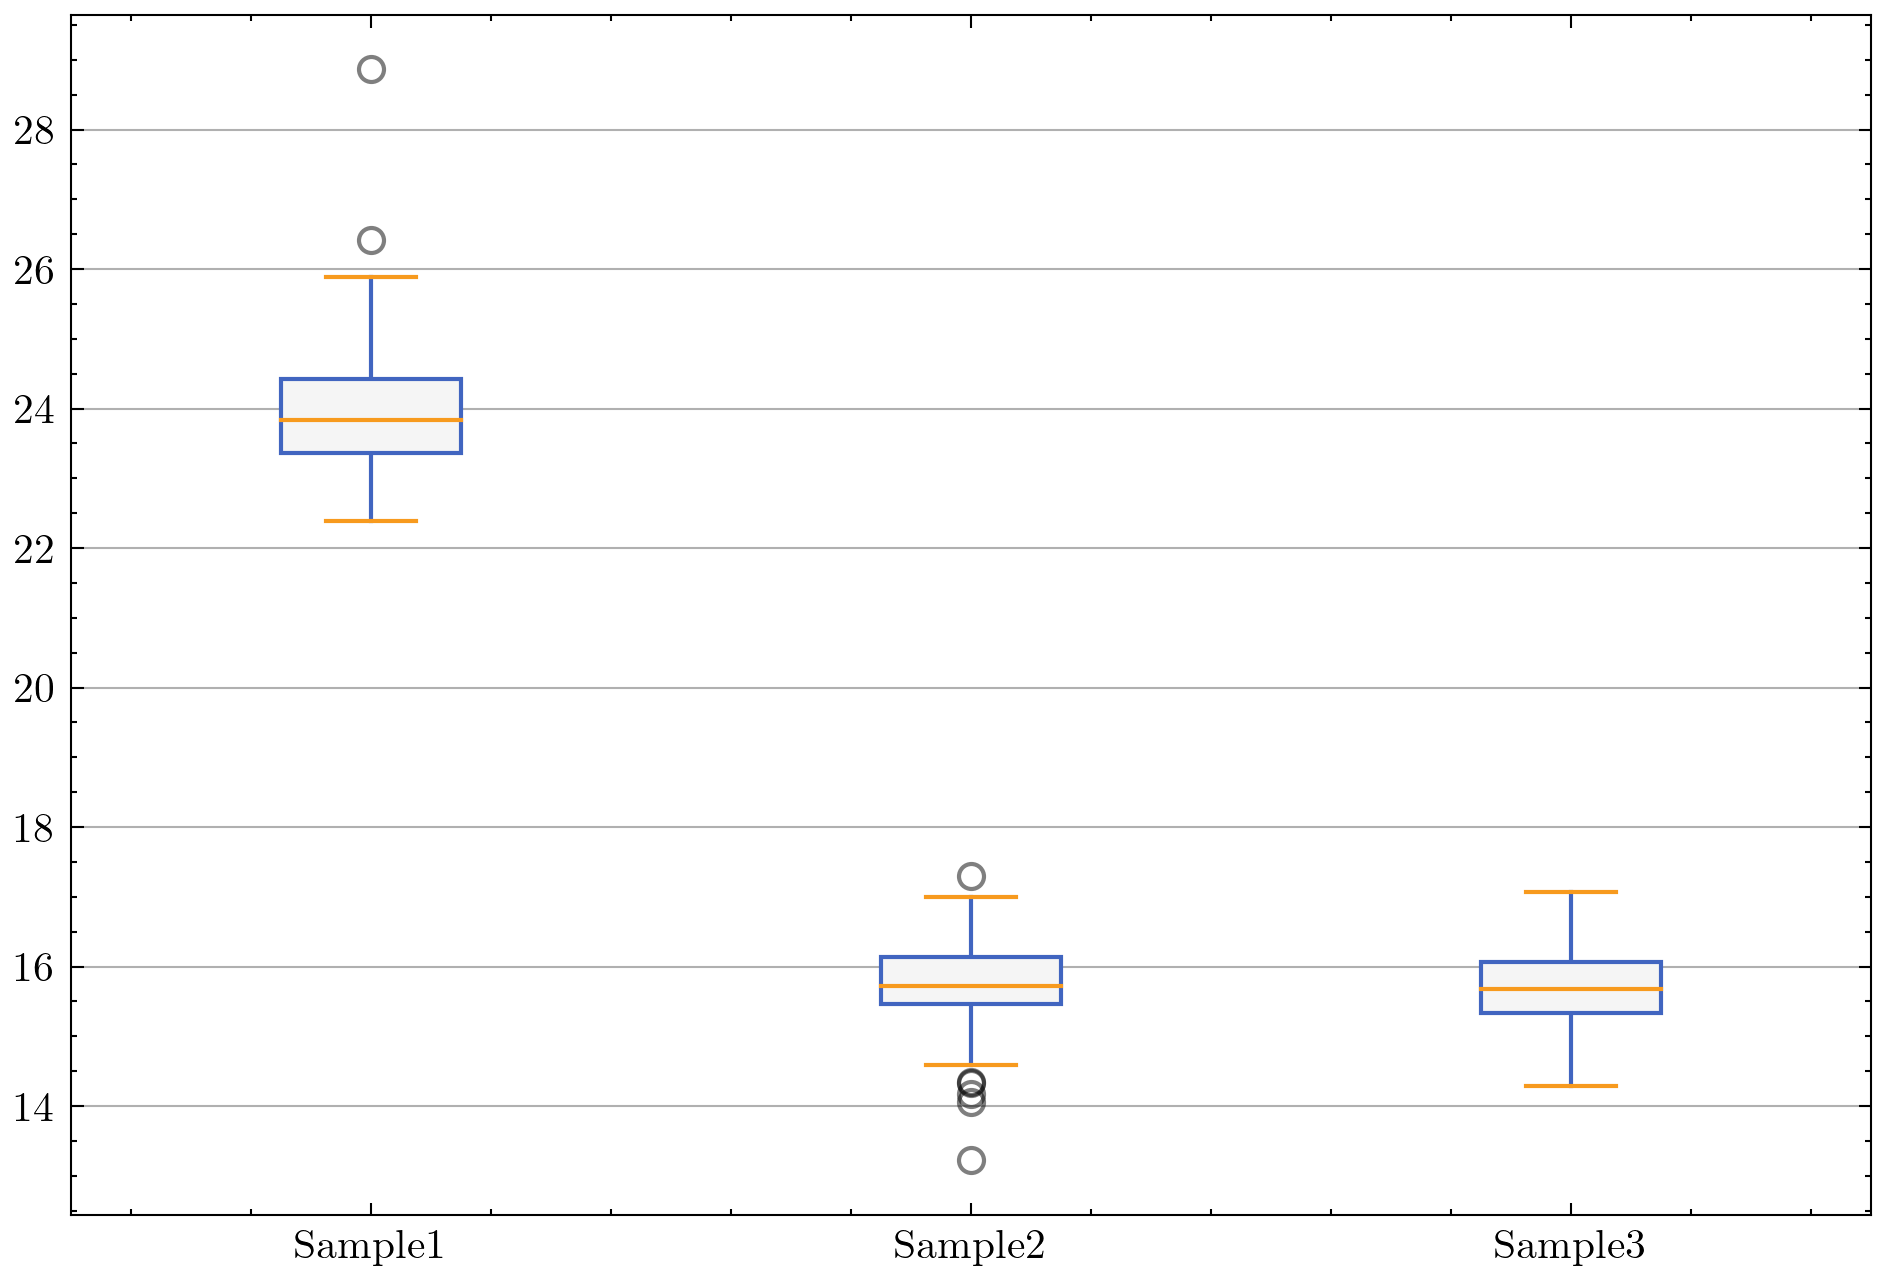

In [9]:

data = [sens_df['MSWA_g_2070'].tolist(),
        sens_df['MSWA_b_2070'].tolist(),
        sens_df['MSWA_e_2070'].tolist()]
fig = plt.figure(figsize =(6, 4), dpi = 300) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1])  
  
# Creating plot 
bp = ax.boxplot(data, patch_artist=True) 

for box in bp['boxes']:
    # change outline color
    box.set( color='#4165c0', linewidth=1)
#     change fill color
    box.set( facecolor = 'whitesmoke')

# change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#4165c0', linewidth=1)

# change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#f79a1e', linewidth=1)

# change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#f79a1e', linewidth=1)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e770a2', alpha = 0.5)

## Customize x-label axis

ax.set_xticklabels(['MSWA_g_2070', 'MSWA_b_2070', 'MSWA_e_2070'])
ax.yaxis.grid(True)

# show plot 
plt.show() 

# Multi-scenario sensitivities

In [47]:
# Here the general boxplots will be created for one product aspect at a time


pol2 = 'NoPol' # NoPol, 
asp = 'GDP'
num_rep = 100

# ['MSWA_g_2045','MSWA_g_2070','MSWA_b_2070','MSWA_e_2070','GDP','HHI_mean','HHI_max','HHI_min','Avg_firms',"Old2045",'Old2070','New2045','New2070','G_loans_per','Idle','G_loans','Cost_pp','Cost_lg']

cases = {"BaseCase":"Base Case", 
         "MS1":"Lower Init. Ineq.",
         "MS2":"Higher Init. Ineq.",
         "Prnew1" : "More Innov. Firms",
         "Prnew2" : "Less Innov. Firms"
         }
uncers = {"Inh" : "Inherent Uncertainties",
          "Prgs": "Lower Success Green",
          "Kg"  : "Lower Impact Green",
        #   "gamma_e1": "Gammae 0.01",
        #   "gamma_e2": "Gammae 0.02",
          "alpha1": "alpha 15",
          "alpha2": "alpha 25"
          }

data = []
name =[]
for cas in cases:
    unc = 'inh'
    temp_df = pd.read_csv("Data/Sens/{}{}{}{}.csv".format(cas,num_rep,unc,pol2))
    data.append(temp_df[asp].tolist())
    name.append(cases[cas])
    if cas == 'BaseCase':
        for unc in uncers:
            if unc != 'Inh':
                temp_df = pd.read_csv("Data/Sens/{}{}{}{}.csv".format(cas,num_rep,unc,pol2))
                data.append(temp_df[asp].tolist())
                name.append(uncers[unc]) 


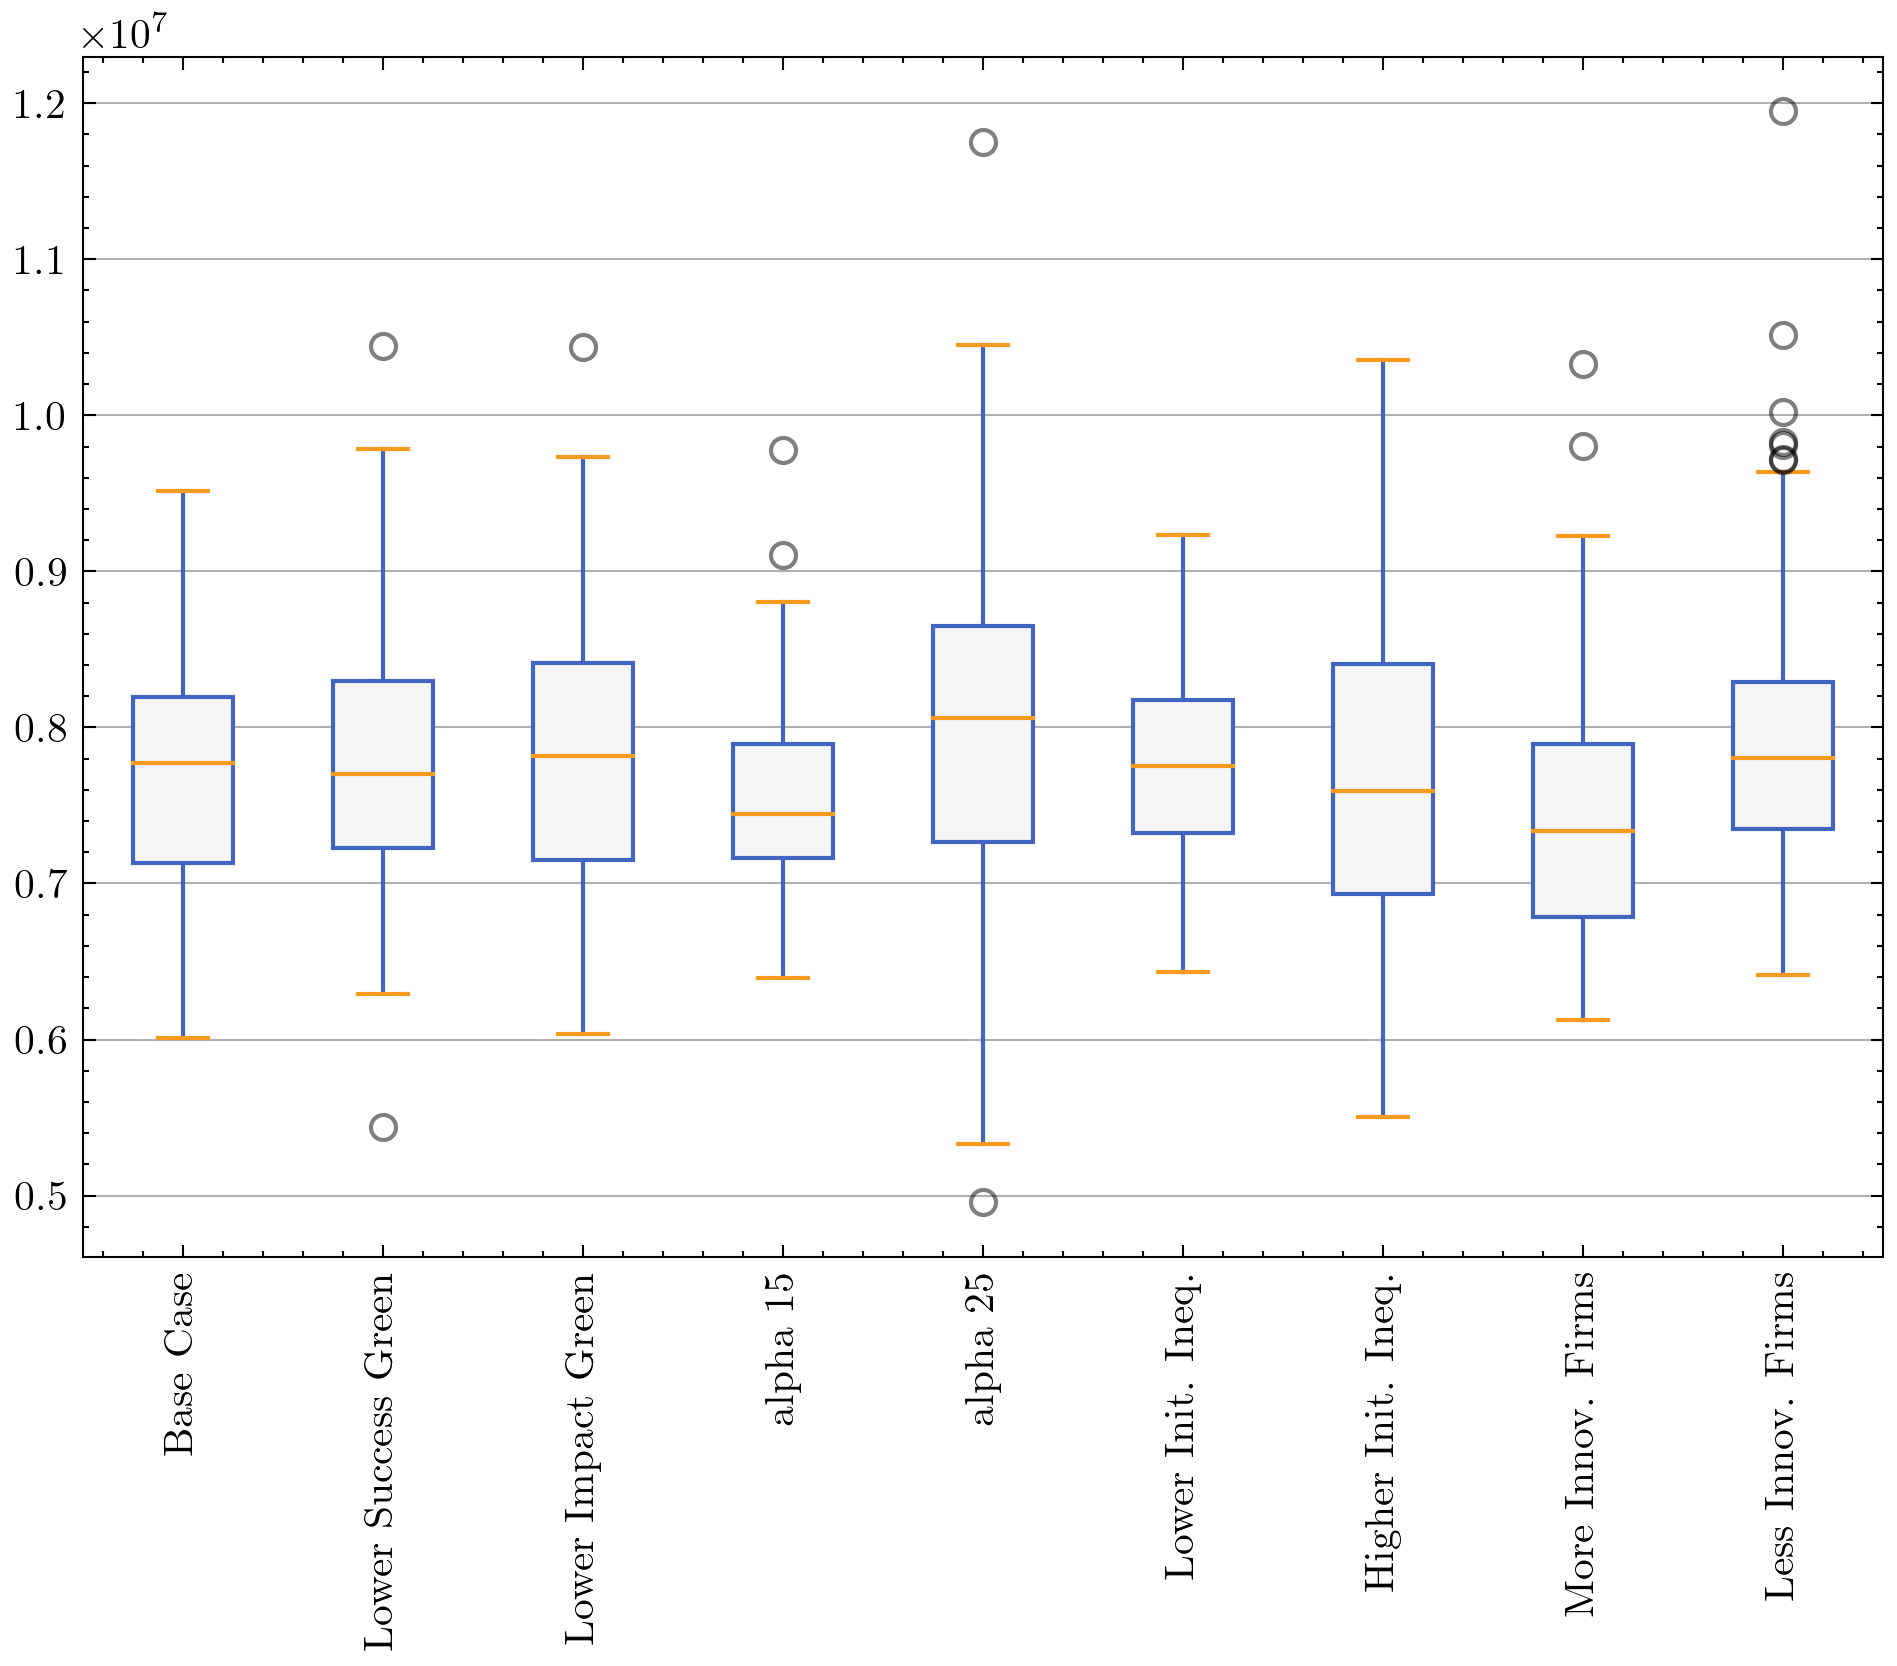

In [48]:
fig = plt.figure(figsize =(6, 4), dpi = 300) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1])  
  
# Creating plot 
bp = ax.boxplot(data, patch_artist=True) 

for box in bp['boxes']:
    # change outline color
    box.set( color='#4165c0', linewidth=1)
#     change fill color
    box.set( facecolor = 'whitesmoke')

# change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#4165c0', linewidth=1)

# change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#f79a1e', linewidth=1)

# change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#f79a1e', linewidth=1)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e770a2', alpha = 0.5)

## Customize x-label axis

ax.set_xticklabels(name)
plt.xticks(rotation = 90)
ax.yaxis.grid(True)

# show plot 
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/NoPolMSWAg2070.pdf')
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/NoPolGDP.pdf')
plt.show() 

In [45]:
# Here the general boxplots will be created for one product aspect at a time


pol2 = 'NoPol' # NoPol, 
asp = 'MSWA_g_2070'
num_rep = 100

# ['MSWA_g_2045','MSWA_g_2070','MSWA_b_2070','MSWA_e_2070','GDP','HHI_mean','HHI_max','HHI_min','Avg_firms',"Old2045",'Old2070','New2045','New2070','G_loans_per','Idle','G_loans','Cost_pp','Cost_lg']

cases = {"BaseCase":"Base Case", 
         "MS1":"Lower Init. Ineq.",
         "MS2":"Higher Init. Ineq.",
         "Prnew1" : "More Innov. Firms",
         "Prnew2" : "Less Innov. Firms"
         }
pols = {
        # "PP20L80C045":"PP20L80C045",
        "PP20L80":"PP20L80",
        # "PP15L80C045":"PP15L80C045",
        "PP15L80":"PP15L80"
        # "PP20L60C045":"PP20L60C045"
        ,"PP20L60":"PP20L60"
        }
              # PP15L80C045, PP20L80C045, PP20L60C045 
              # PP15L80 , PP20L80, PP20L60
uncers = {"Inh" : "Inherent Uncertainties",
          "Prgs": "Lower Success Green",
          "Kg"  : "Lower Impact Green",
        #   "gamma_e1": "Gammae 0.01",
        #   "gamma_e2": "Gammae 0.02",
          "alpha1": "alpha 15",
          "alpha2": "alpha 25"
          }

data2 = []
name2 =[]

for pol in pols:
    unc2 = 'Inh'
    for cas2 in ["BaseCase", "MS2"]:
    # cas2 = 'BaseCase' # MS1, MS2, 
        temp_df = pd.read_csv("Data/Sens/{}{}{}{}.csv".format(cas2,num_rep,unc2,pol))
        data2.append(temp_df[asp].tolist())
        name2.append(pols[pol]+cas2)
        

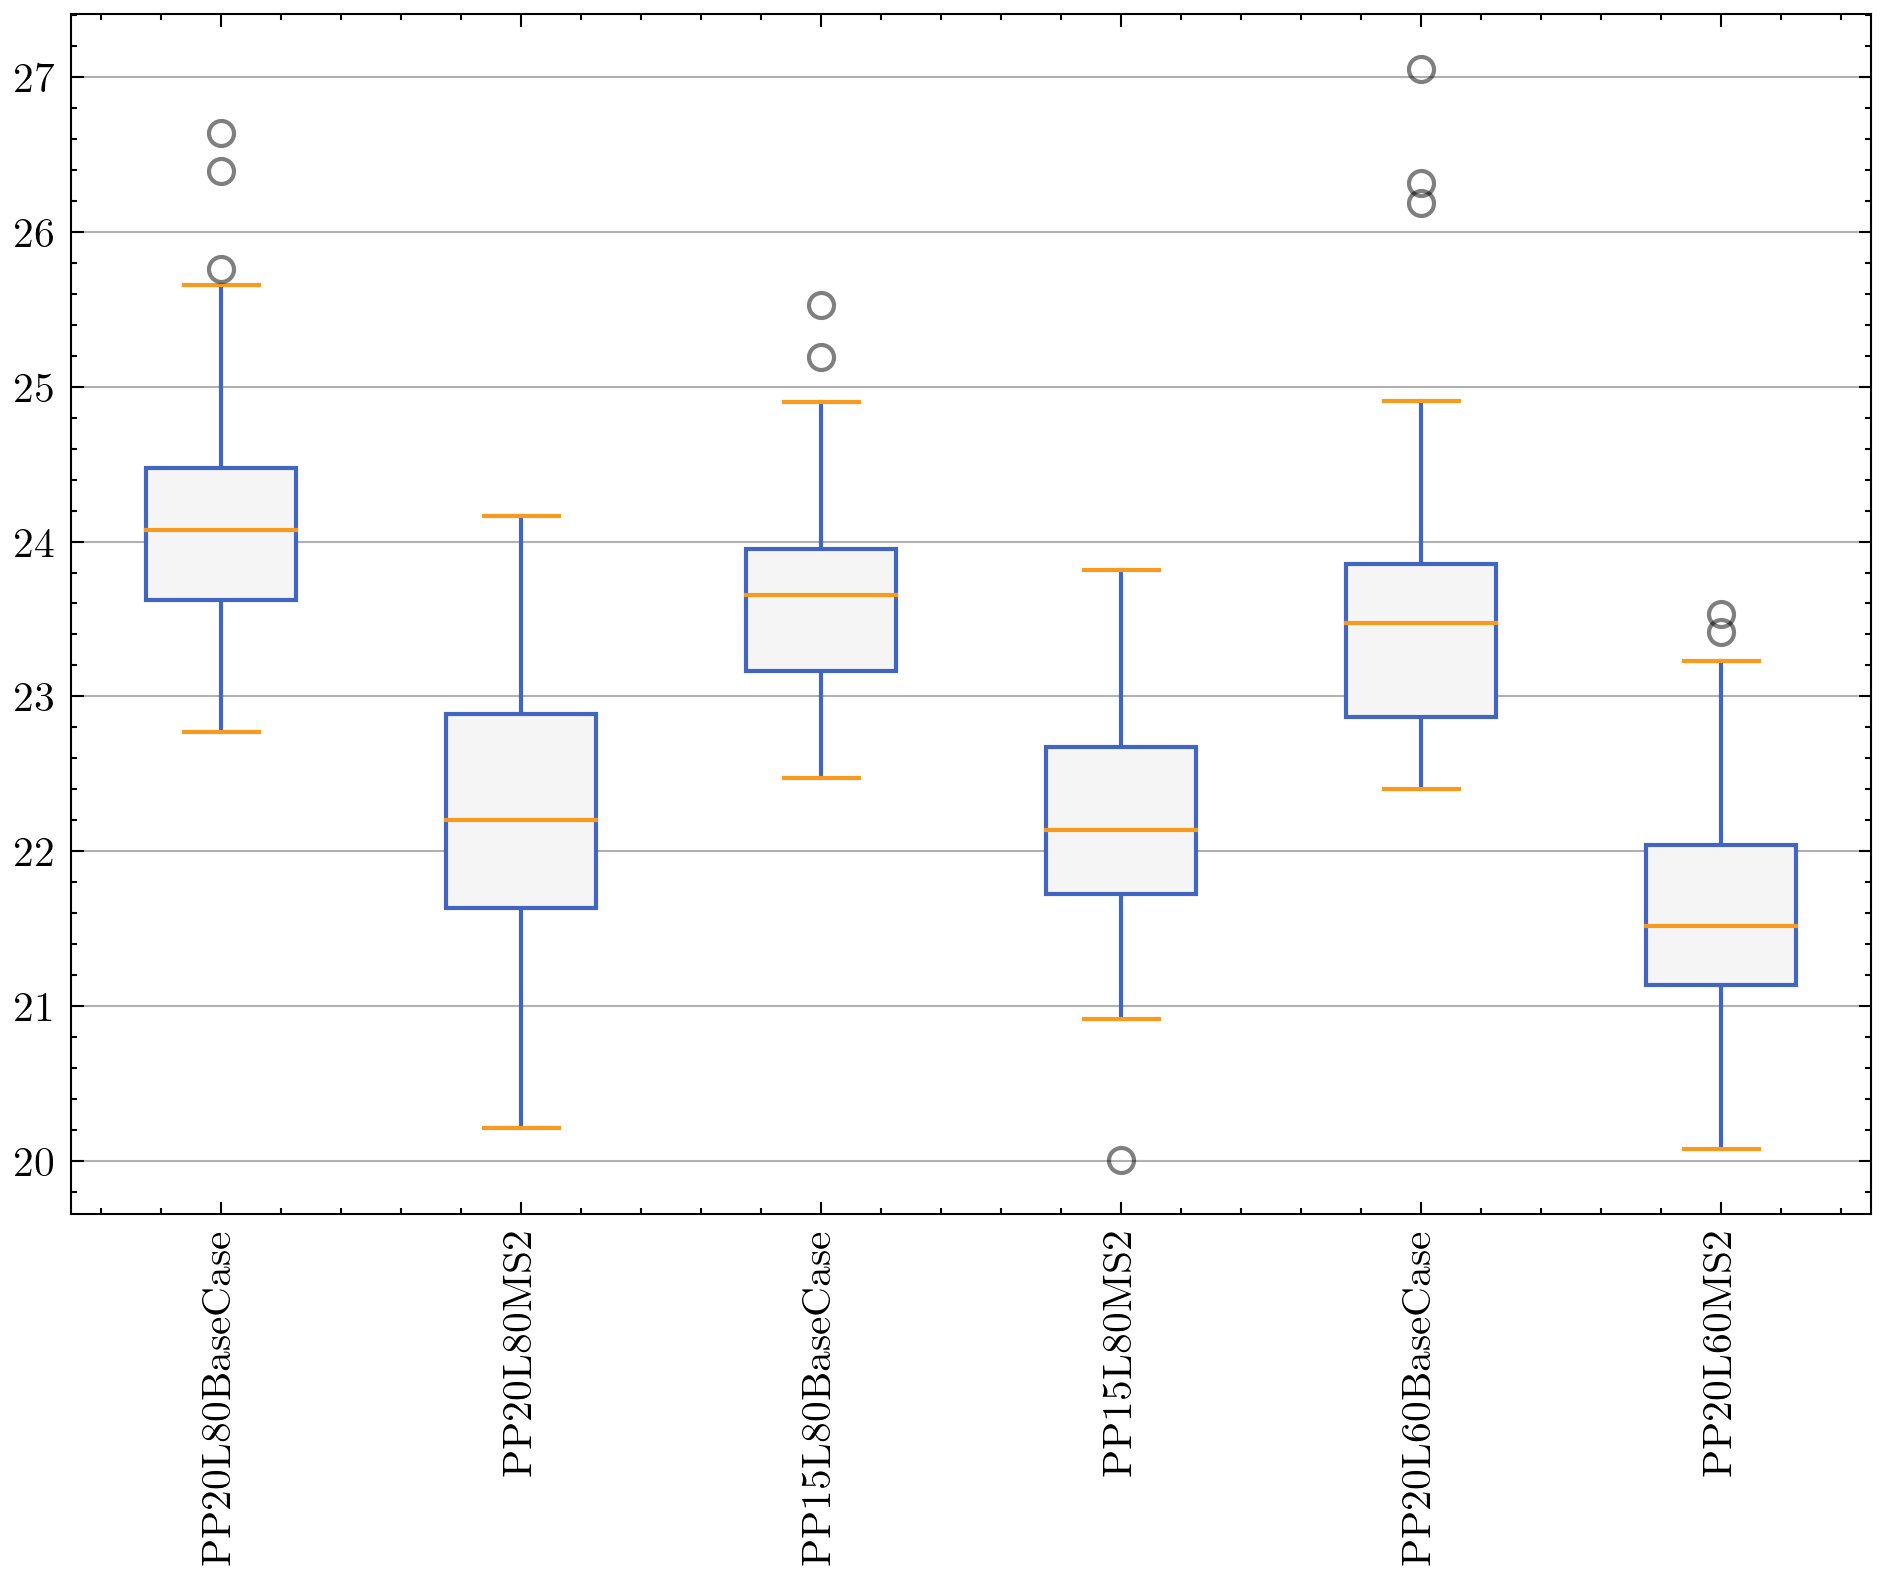

In [46]:
fig = plt.figure(figsize =(6, 4), dpi = 300) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1])  
  
# Creating plot 
bp = ax.boxplot(data2, patch_artist=True) 

for box in bp['boxes']:
    # change outline color
    box.set( color='#4165c0', linewidth=1)
#     change fill color
    box.set( facecolor = 'whitesmoke')

# change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#4165c0', linewidth=1)

# change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#f79a1e', linewidth=1)

# change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#f79a1e', linewidth=1)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e770a2', alpha = 0.5)

## Customize x-label axis

ax.set_xticklabels(name2)
plt.xticks(rotation = 90)
ax.yaxis.grid(True)

# show plot 
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/NoPolMSWAg2070.pdf')
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/ConPrefMSWAg2070.pdf')
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/NoPolGDP.pdf')
# plt.savefig('../Writing/My_Thesis/Chapters/Analysis/Images/ConPrefGDP.pdf')
plt.show() 